In [248]:
from __future__ import print_function, division
#Import BeautifulSoup
from bs4 import BeautifulSoup
#Regular expressions compiler
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline
# %pylab inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score

In [249]:
with open('hosp.pickle','rb') as read_file:
    hosp = pickle.load(read_file)
    
hosp.info()
hosp.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 0 to 1286
Data columns (total 45 columns):
provider_id                                                                          1188 non-null object
start_date                                                                           1188 non-null object
end_date                                                                             1188 non-null object
weighted_avg_EXCESS                                                                  1188 non-null float64
weighted_avg_PRR                                                                     1188 non-null float64
weighted_avg_ERR                                                                     1188 non-null float64
number_of_discharges                                                                 1188 non-null float64
number_of_readmissions                                                               1188 non-null float64
raw_avg_readmitrate                     

,provider_id,start_date,end_date,weighted_avg_EXCESS,weighted_avg_PRR,weighted_avg_ERR,number_of_discharges,number_of_readmissions,raw_avg_readmitrate,measure_name,...,safety_of_care_national_comparison_Below the national average,safety_of_care_national_comparison_Same as the national average,patient_experience_national_comparison_Below the national average,patient_experience_national_comparison_Same as the national average,effectiveness_of_care_national_comparison_Below the national average,effectiveness_of_care_national_comparison_Same as the national average,timeliness_of_care_national_comparison_Below the national average,timeliness_of_care_national_comparison_Same as the national average,efficient_use_of_medical_imaging_national_comparison_Below the national average,efficient_use_of_medical_imaging_national_comparison_Same as the national average
0,010001,07/01/2014,06/30/2017,1.0468,5.0853,4.8582,335.0,18.0,0.053731,1,...,0,0,1,0,0,1,0,0,0,1
1,010055,07/01/2014,06/30/2017,1.0961,4.3096,3.9316,490.0,23.0,0.046939,1,...,0,0,0,1,0,1,0,0,0,0
2,010005,07/01/2014,06/30/2017,1.0913,5.3414,4.8946,284.0,17.0,0.059859,1,...,1,0,0,1,0,0,0,0,1,0
3,010006,07/01/2014,06/30/2017,1.3032,5.6779,4.3570,431.0,30.0,0.069606,1,...,0,0,1,0,0,1,0,0,1,0
4,010019,07/01/2014,06/30/2017,1.0077,3.9911,3.9606,422.0,17.0,0.040284,1,...,0,0,0,1,0,1,0,0,1,0


In [251]:
#Check correlation of continuous variables

hosp1 = hosp.loc[:,['weighted_avg_PRR','number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
                 '3_Year_Avg_Hourly_Wage','median_household_income','some_college_or_higher']]
# #remove the alternative outcome calcs
# hosp = hosp.drop(columns=['number_of_readmissions','raw_avg_readmitrate',
#                           'measure_name','weighted_avg_ERR','weighted_avg_EXCESS'])

#'3_Year_Avg_Hourly_Wage_15_16_17','median_household_income',
hosp1.corr()

,weighted_avg_PRR,number_of_discharges,Case_Mix_Indexes,FY_Wage_Index,3_Year_Avg_Hourly_Wage,median_household_income,some_college_or_higher
weighted_avg_PRR,1.000000,-0.432037,-0.242024,-0.072639,-0.116383,-0.126085,-0.263249
number_of_discharges,-0.432037,1.000000,0.332582,0.050665,0.134729,0.105382,0.206354
Case_Mix_Indexes,-0.242024,0.332582,1.000000,0.071494,0.202795,-0.015699,0.220499
FY_Wage_Index,-0.072639,0.050665,0.071494,1.000000,0.905313,0.569484,0.292933
3_Year_Avg_Hourly_Wage,-0.116383,0.134729,0.202795,0.905313,1.000000,0.549929,0.336003
median_household_income,-0.126085,0.105382,-0.015699,0.569484,0.549929,1.000000,0.645928
some_college_or_higher,-0.263249,0.206354,0.220499,0.292933,0.336003,0.645928,1.000000


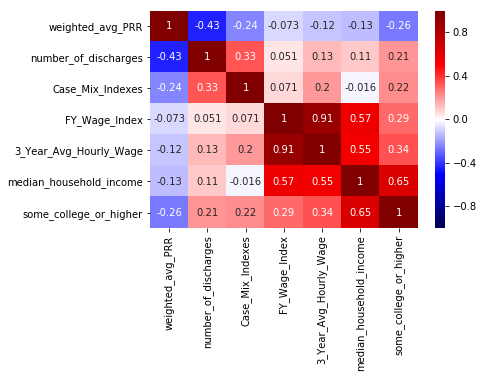

In [252]:
sns.heatmap(hosp1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

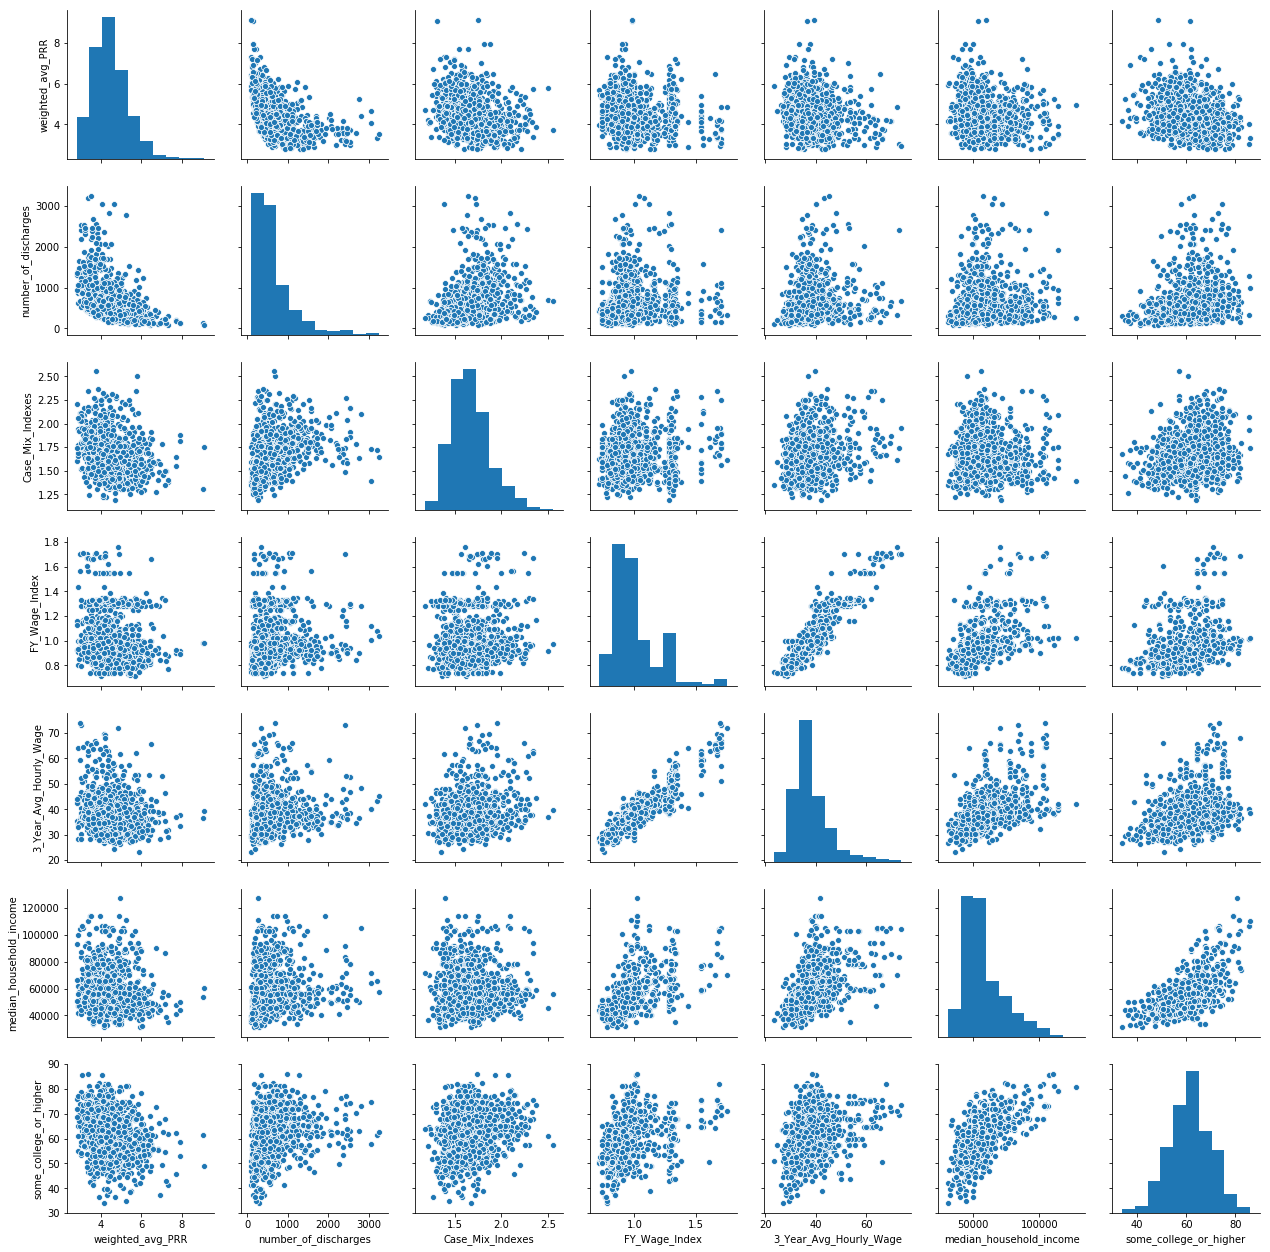

In [253]:
sns.pairplot(hosp1);

### Simple linear regression of continuous variables

In [255]:
# Define the model
# lm1 = smf.ols('weighted_avg_PRR ~ FY_2017_Wage_Index + Case_Mix_Indexes + median_household_income', data=hosp)
lm1 = smf.ols('weighted_avg_PRR ~ Case_Mix_Indexes + number_of_discharges + FY_Wage_Index + median_household_income + some_college_or_higher', data=hosp)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       weighted_avg_PRR   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     68.68
Date:                Sat, 05 Oct 2019   Prob (F-statistic):           4.04e-63
Time:                        22:36:47   Log-Likelihood:                -1355.4
No. Observations:                1188   AIC:                             2723.
Df Residuals:                    1182   BIC:                             2753.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   6.5412      0.237     27.627      0.000       6.077       7.006
Case_Mix_Indexes           -0.2987      0.117     -2.556      0.011      -0.528      -0.069
number_of_discharges       -0.0007   5.06e-05    -13.524      0.000      -0.001      -0.001
FY_Wage_Index              -0.0901      0.146     -0.619      0.536      -0.376       0.196
median_household_income  2.825e-06   2.27e-06      1.247      0.213   -1.62e-06    7.27e-06
some_college_or_higher     -0.0200      0.004     -5.526      0.000      -0.027      -0.013
==============================================================================
Omnibus:                      177.433   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.543
Skew:                           0.920   Prob(JB):                     1.24e-71
Kurtosis:                       4.791   Cond. No.                     6.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Split data into train/validate/test sets

In [271]:
X, y = hosp.drop(['weighted_avg_PRR','weighted_avg_ERR','weighted_avg_EXCESS',
                  'raw_avg_readmitrate','number_of_readmissions','measure_name',
                  'provider_id','start_date','end_date','hospital_name','state',
                  'zip_code','county_name','hospital_type','county_st','3_Year_Avg_Hourly_Wage'],axis=1), hosp['weighted_avg_PRR']
#                   '3_Year_Avg_Hourly_Wage_15_16_17',
#                   'mortality_national_comparison_Below the national average',
#                   'mortality_national_comparison_Not Available',
#                   'mortality_national_comparison_Same as the national average',
#                   'hospital_overall_rating_2','hospital_overall_rating_3','hospital_overall_rating_4',
#                   'hospital_overall_rating_5','hospital_overall_rating_Not Available'
#                  emergency_services_True                                           2716 non-null uint8
# hospital_ownership_Government - Hospital District or Authority    2716 non-null uint8
# hospital_ownership_Government - Local                             2716 non-null uint8
# hospital_ownership_Government - State                             2716 non-null uint8
# hospital_ownership_Physician                                      2716 non-null uint8
# hospital_ownership_Proprietary                                    2716 non-null uint8
# hospital_ownership_Tribal                                         2716 non-null uint8
# hospital_ownership_Voluntary non-profit - Church                  2716 non-null uint8
# hospital_ownership_Voluntary non-profit - Other                   2716 non-null uint8
# hospital_ownership_Voluntary non-profit - Private  
                 
#                  ],axis=1), hosp['weighted_avg_PRR']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2)

In [272]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25)

In [273]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [274]:
#validate
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.293
Ridge Regression val R^2: 0.296
Degree 2 polynomial regression val R^2: -4241450.485


In [275]:
lm.fit(X, y)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')


Linear Regression val R^2: 0.348


### Ridge Regularization test

In [261]:
ridge_model = Ridge(alpha = 10)
ridge_model.fit(X_train, y_train)

list(zip(X_train.columns, ridge_model.coef_))

[('number_of_discharges', -0.0005709578747020514),
 ('Case_Mix_Indexes', -0.24787991126980052),
 ('FY_Wage_Index', -0.19577244266442084),
 ('median_household_income', 1.7295018939871166e-06),
 ('some_college_or_higher', -0.01630253727989557),
 ('emergency_services_True', -8.388232057173912e-05),
 ('hospital_ownership_Government - Hospital District or Authority',
  -0.020479556708228968),
 ('hospital_ownership_Government - Local', -0.2545874912443333),
 ('hospital_ownership_Government - State', 0.2423921178474128),
 ('hospital_ownership_Proprietary', 0.10496662201224166),
 ('hospital_ownership_Voluntary non-profit - Church', -0.0058440463550410845),
 ('hospital_ownership_Voluntary non-profit - Other', -0.014765262478628315),
 ('hospital_ownership_Voluntary non-profit - Private', -0.0789306050721503),
 ('hospital_overall_rating_2', -0.06992609998000679),
 ('hospital_overall_rating_3', -0.11979027433789598),
 ('hospital_overall_rating_4', -0.2398313534740547),
 ('hospital_overall_rating_5

### Lasso Regularization test

In [262]:
lasso_model = Lasso(alpha = 10)
lasso_model.fit(X_train, y_train)

list(zip(X_train.columns, lasso_model.coef_))

[('number_of_discharges', -0.0006708344747135942),
 ('Case_Mix_Indexes', -0.0),
 ('FY_Wage_Index', -0.0),
 ('median_household_income', -4.898285645313004e-06),
 ('some_college_or_higher', -0.0),
 ('emergency_services_True', -0.0),
 ('hospital_ownership_Government - Hospital District or Authority', 0.0),
 ('hospital_ownership_Government - Local', -0.0),
 ('hospital_ownership_Government - State', 0.0),
 ('hospital_ownership_Proprietary', 0.0),
 ('hospital_ownership_Voluntary non-profit - Church', 0.0),
 ('hospital_ownership_Voluntary non-profit - Other', 0.0),
 ('hospital_ownership_Voluntary non-profit - Private', -0.0),
 ('hospital_overall_rating_2', 0.0),
 ('hospital_overall_rating_3', 0.0),
 ('hospital_overall_rating_4', -0.0),
 ('hospital_overall_rating_5', -0.0),
 ('mortality_national_comparison_Below the national average', -0.0),
 ('mortality_national_comparison_Same as the national average', -0.0),
 ('safety_of_care_national_comparison_Below the national average', 0.0),
 ('safety_

In [244]:
# Lars path visualization?

### Graphing the linear model

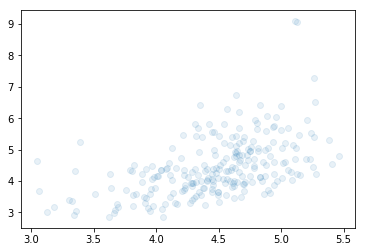

In [270]:
test_set_pred = lm.predict(X_test)

plt.scatter(test_set_pred, y_test, alpha=.1);
# plt.plot(np.linspace(2,10,1), np.linspace(2,10,1))

In [264]:
r2_score(y_test, test_set_pred)

0.26397074436830215

In [265]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

0.607883164466897

In [197]:
plt.figure(figsize=(12,8))
plt.scatter(lm.predict(X_test), lm.resid);

AttributeError: 'LinearRegression' object has no attribute 'resid'

<Figure size 864x576 with 0 Axes>

In [ ]:
#add dummy variables
#split - split and validate function
#plot residuals
#plot with polynomial regression
#regularize
#test it on the test data